In [1]:
import numpy as np 
from BFEE2.postTreatment import postTreatment
import math
import plumed
from BFEE2.commonTools.ploter import mergePMF, writePMF
import matplotlib.pyplot as plt
from jinja2 import Template

In [2]:

def readPMF(filePath):
    """read a 1D PMF file

    Args:
        filePath (str): the path of the PMF file

    Returns:
        np.array (float, 2*N): ((x0,x1,x2, ...), (y0, y1, y2, ...))
    """

    data = np.loadtxt(filePath)
    x = data[:, 0]
    y = data[:, 1]

    return np.array((x, y))

def geometricRestraintContribution(pmf, forceConstant, beta, rmsd=False, unbound=False):
    """calculate the contribution of RMSD and angle restraints

    Args:
        pmf (np.array, float, 2*N): ((x0,x1,x2, ...), (y0, y1, y2, ...))
        forceConstant (float): the force constant of the restraint
        rmsd (bool): whether the contribution of RMSD is being calculated. Defaults to False.
        unbound (bool, optional): whether unbound-state contribution is being calculated. Defaults to False.

    Returns:
        float: contribution of the geometric restraint
    """

    if rmsd:
        # for RMSD, the restraintCenter is zero
        restraintCenter = 0
    else:
        # the minimum of pmf
        restraintCenter = pmf[0][np.argmin(pmf[1])]

    # integration
    numerator = 0
    denominator = 0
    for x, y in zip(pmf[0], pmf[1]):
        numerator += math.exp(-beta * y)
        denominator += math.exp((-beta) * (y + 0.5 * forceConstant * ((x - restraintCenter)**2)))
        
    contribution = math.log(numerator / denominator) / beta

    if unbound:
        return contribution
    else:
        return -contribution

In [3]:
def limitrange(pmf, lower=0, upper=1.75):
    temp_pmf = []
    for x, y in zip(pmf[0], pmf[1]):
        if  lower <= x and x <=upper:
            temp_pmf.append([x, y])
    return np.array(temp_pmf).T

In [4]:

TEMPERATURE = 300 # k
BOLTZMANN = 0.0019872041 # kacl/mol 
beta =  1 / (BOLTZMANN * TEMPERATURE)

In [5]:
# RMSDBOUND NAMD 
forceConstant = 0.1 # kcal/mol A2
pmf_path =  '../../../BFEE2_NAMD_2wi3/BFEE_NAMD/005_PolarTheta/output/abf_1.abf1.czar.pmf'
pmf_namd = readPMF(pmf_path)
#print(pmf.shape)
# pmf2 = limitrange(pmf, 0, 1.75)
# print(pmf2.shape)
dG = geometricRestraintContribution(pmf_namd, forceConstant, beta, rmsd=False, unbound=False)
print(f'dG = {dG:.3f} kcal/mol')

dG = -0.632 kcal/mol


In [6]:
data = plumed.read_as_pandas("../../openmm_plumed/005_PolarTheta/fes.dat")
#data = plumed.read_as_pandas("../hills_polartheta_plumed/fes.dat")
pmf_plumed = np.array([data["polarTheta"], data["file.free"]/4.184])
print(pmf_plumed.shape)
#pmf2_op = limitrange(pmf_op, 0, 1.75)
#print(pmf2_op.shape)
dG = geometricRestraintContribution(pmf_plumed, forceConstant, beta, rmsd=False, unbound=False)
print(f'dG = {dG:.3f} kcal/mol')

(2, 51)
dG = -0.593 kcal/mol


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/ndonyapour/tools_drivers/plumed2-2.8.1/src/lib/libplumedKernel.so" +++


In [11]:
data = plumed.read_as_pandas("../005_PolarTheta/fes.dat")
pmf_op = np.array([data["polarTheta"], data["file.free"]/4.184])
print(pmf_op.shape)
#pmf2_op = limitrange(pmf_op, 0, 1.75)
#print(pmf2_op.shape)
dG = geometricRestraintContribution(pmf_op, forceConstant, beta, rmsd=False, unbound=False)
print(f'dG = {dG:.3f} kcal/mol')

(2, 197)
dG = -0.523 kcal/mol


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/ndonyapour/tools_drivers/plumed2-2.8.1/src/lib/libplumedKernel.so" +++


In [9]:
print(min(pmf_plumed[0, :]), max(pmf_plumed[0, :]))
print(min(pmf_op[0, :]), max(pmf_op[0, :]))

45.0674 88.937
48.527 87.0038


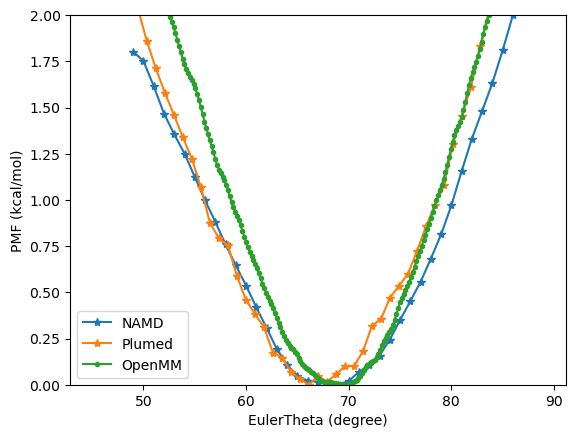

In [10]:
plt.plot(*pmf_namd, "*-", label="NAMD")
plt.plot(*pmf_plumed, "*-", label="Plumed")
plt.plot(*pmf_op, ".-", label="OpenMM")
plt.legend(loc="best")
plt.ylabel("PMF (kcal/mol)")
plt.xlabel("EulerTheta (degree)")
plt.ylim([0, 2])
#plt.xlim([-, 15])
plt.savefig("figures/polarTheta_NAMD_Plumed_OpenMM_pmf.png")

In [21]:
# calculate_free_energy
temperature = 300
import shutil
unit ='namd'
ps = postTreatment(temperature, unit, jobType='geometric') 
pmf_paths = []
steps = ['RMSDBound', 'EulerTheta', 'EulerPhi', 'EulerPsi', 'PolarTheta', 'PolarPhi', 'r', 'RMSDUnbound']
for i in range(1, 9):
    pmf_paths.append(f'../BFEE_NAMD/00{i}_{steps[i-1]}/output/abf_1.abf1.czar.pmf')
    shutil.copy(f'../BFEE_NAMD/00{i}_{steps[i-1]}/output/abf_1.abf1.czar.pmf', f'../outputs/00{i}_{steps[i-1]}.abf1.czar.pmf')
# print(pmf_paths)  
# # (forceConstant1, FC2, FC3, FC4, FC5, FC6, r*, FC8)
#r* < 007_pmf[0][-1]
forceconstants = np.array([10, 0.1, 0.1, 0.1, 0.1, 0.1, 28.0, 10])
dGs = ps.geometricBindingFreeEnergy(pmf_paths, forceconstants)

dGs_str = ["ΔG(site,c):", "ΔG(site,eulerTheta):", "ΔG(site,eulerPhi):", "ΔG(site,eulerPsi):", "ΔG(site,polarTheta):",
           "ΔG(site,polarPhi):","(1/beta)*ln(S*I*C0):", "ΔG(bulk,c):", "ΔG(bulk,o):", "ΔG(total):"]

for i, dg in enumerate(dGs):
    print(f"{dGs_str[i]} {dg:.2f} kcal/mol")

ΔG(site,c): -0.55 kcal/mol
ΔG(site,eulerTheta): -0.44 kcal/mol
ΔG(site,eulerPhi): -0.59 kcal/mol
ΔG(site,eulerPsi): -0.46 kcal/mol
ΔG(site,polarTheta): -0.63 kcal/mol
ΔG(site,polarPhi): -0.51 kcal/mol
(1/beta)*ln(S*I*C0): -5.91 kcal/mol
ΔG(bulk,c): 2.09 kcal/mol
ΔG(bulk,o): 6.61 kcal/mol
ΔG(total): -0.40 kcal/mol
